In [1]:
import multiprocessing
print(f'num cpus: {multiprocessing.cpu_count()}')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import frame_whitening as fw
import frame_whitening.plot as fwplt
from frame_whitening import simulation as fws

num cpus: 128


In [2]:
seed = 42069
np.random.seed(seed)
n, k = 2, 3
n_batch = 10000
lr_g = 2E-3
online = True
batch_size = 1
error_type = "operator"

theta = np.deg2rad(55)
V = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Cxx0 = V @ np.diag([4, 1]) @ V.T * 0.1
Cxx0 *= 50

# V, _ = np.linalg.qr(np.random.randn(n, n))
Cxx1 = V @ np.diag([3, 2]) @ V.T * 0.1
Cxx1 *= 40

cholesky_list = [np.linalg.cholesky(C) for C in [Cxx0, Cxx1]]
Cxx_list = (Cxx0, Cxx1)
W = fw.get_mercedes_frame()
W = np.array([[0, 1, 1], [1, 1, 0]])
W = fw.normalize_frame(W)

g0 = np.array([0.01, 1.2, 0.25])
g, g_all, errors, variances = fws.adapt_covariance(Cxx_list, W, batch_size, n_batch, lr_g, g0=g0, online=online, seed=seed, break_on_convergence=False, error_type=error_type)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 7051.11it/s]


In [3]:
def get_variances(g, W, Cxx):
    N = W.shape[0]
    Ixx = np.eye(N)
    WGW = W @ np.diag(g) @ W.T
    M = np.linalg.inv(Ixx + WGW)
    Cyy = M @ Cxx @ M.T
    Czz = W.T @ Cyy @ W
    variances = np.diag(Czz)
    return variances

vars = []
g_all2 = [g for g in g_all]
for j, Cxx in enumerate([Cxx0, Cxx1]):
    for i in range(n_batch):
        vars.append(get_variances(g_all2.pop(0), W, Cxx))

vars = np.stack(vars)

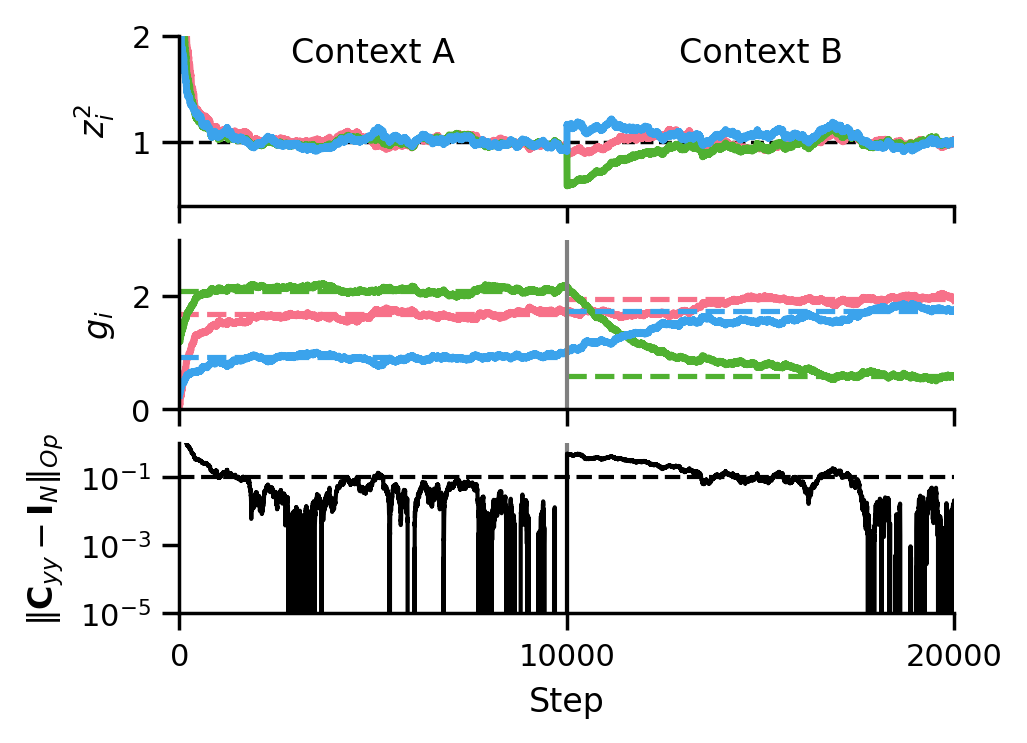

In [6]:
with sns.plotting_context("paper", font_scale=1):

    cols = sns.color_palette("husl", 3)
    fig, ax = plt.subplots(3, 1, figsize=(4, 3), sharex="all", dpi=250)

    for i in range(k):
        ax[0].plot(vars[:,i], color=cols[i], linewidth=2)


    ax[0].hlines(
        1, 1, 2*n_batch, color="k", linestyle="--", linewidth=1.,  zorder=-1)


    g_opt0 = fws.get_g_opt(W, Cxx0)
    g_opt1 = fws.get_g_opt(W, Cxx1)
    g_opt = [g_opt0, g_opt1]

    for i in range(k):
        ax[1].plot(g_all[:,i], color=cols[i], linewidth=2)
        ax[1].hlines(g_opt0[i], 0, n_batch, color=cols[i], linestyle='--', lw=1.5)
        ax[1].hlines(g_opt1[i], n_batch, 2*n_batch, color=cols[i], linestyle='--', lw=1.5)
    ax[1].vlines(n_batch, 0, 3, color="grey", linestyle='-')
    ax[2].vlines(n_batch, 1E-10, 1, color="grey", linestyle='-')
    ax[2].hlines(.1, 0, 2*n_batch, color="k", linestyle='--')

    ax[0].set(ylabel=r"$z_i^2$", yscale="linear", ylim=(.4, 2))
    ax[1].set(ylabel=r"$g_i$", xlim=(0, n_batch * len(cholesky_list)), ylim=(0, 3),
    xticks=(0, n_batch, 2*n_batch))
    ax[2].plot(errors, "k")

    ylabel = r"$\frac{1}{N}\sum_i^N (\lambda_i - 1)^2$" if error_type == "spectral" else r"$\frac{1}{N^2}\Vert{\bf C}_{yy} - {\bf I}_N\Vert_{F}^2$"
    ylabel = r"$\Vert {\bf C}_{yy} - {\bf I}_N \Vert_{Op}$"
    ax[2].set(
        ylabel=ylabel,
        xlabel="Step", 
        yscale="log", ylim=(1E-4, 1E0),
        yticks=(1E-5, 1E-3, 1E-1),
    )

    # write text in first half saying Context A
    ax[0].text(0.25, 0.9, "Context A", transform=ax[0].transAxes, ha="center", va="center")
    # write text in second half saying Context B
    ax[0].text(.75, 0.9, "Context B", transform=ax[0].transAxes, ha="center", va="center")

    sns.despine()

# save as pdf

fig.savefig("figures/icml2023/2_loss_go_down.pdf", bbox_inches="tight", transparent=True)